In [20]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
#%matplotlib inline doesn't seem to play nice with jupyter lab
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import chain

%matplotlib inline
##Import any other packages you may need here

In [8]:
!ls ./data/ | grep -i data


Data_Entry_2017.csv


In [10]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
all_xray_df = pd.read_csv('./data/Data_Entry_2017.csv')
data_sample = pd.read_csv('sample_labels.csv')

In [11]:
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
36644,00009646_000.png,Emphysema,0,9646,83,M,PA,2500,2048,0.168,0.168,NaN
99287,00026259_000.png,No Finding,0,26259,57,F,PA,2770,2738,0.143,0.143,NaN
25048,00006600_002.png,Infiltration,2,6600,72,M,AP,2500,2048,0.171,0.171,NaN


In [12]:
data_sample.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
3633,00017906_010.png,No Finding,10,17906,022Y,M,PA,2658,2387,0.143,0.143
1542,00008009_000.png,No Finding,0,8009,015Y,M,PA,2798,2991,0.143,0.143
5177,00027652_003.png,Atelectasis|Pneumothorax,3,27652,049Y,M,AP,3056,2544,0.139,0.139


What are we looking at here?


EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Also, **describe your findings and how will you set up the model training based on the findings.**

## The student can create visualizations of the metadata that inform model training

In [46]:
# Let's start with a review the full compliment of diseases we're looking at.
all_xray_df['Finding Labels'].value_counts()[:10]

No Finding                  60361
Infiltration                 9547
Atelectasis                  4215
Effusion                     3955
Nodule                       2705
Pneumothorax                 2194
Mass                         2139
Effusion|Infiltration        1603
Atelectasis|Infiltration     1350
Consolidation                1310
Name: Finding Labels, dtype: int64

In [45]:
# There appear to be some comorbitities to account for here. Let's add columns to label each of these
# as binary classifications (snippet from lesson x to start this)
unique_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
unique_labels

array(['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
       'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration',
       'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia',
       'Pneumothorax'], dtype='<U18')

In [48]:
# Binary column for presence or abense of each label 
for x in unique_labels:
    all_xray_df[x] = [x in label for label in all_xray_df['Finding Labels']]
    
# This is going to be a boolean, but that suits me

In [49]:
# Quick sanify check
list(all_xray_df)

['Image Index',
 'Finding Labels',
 'Follow-up #',
 'Patient ID',
 'Patient Age',
 'Patient Gender',
 'View Position',
 'OriginalImage[Width',
 'Height]',
 'OriginalImagePixelSpacing[x',
 'y]',
 'Unnamed: 11',
 'Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'No Finding',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

Moving on. Now that we have this, let's take a look at some out our citeria.  
**Students create distributions of diseases and comorbidities in their dataset**

The thing about this dataset, I think we might have multiple images per patient. If this is the case, and there is an _unequal_ number of images per patient, we could have unequal counts of diseases (as well as any other column: demographics etc). The `Subject ID` appears to provide a means to address this. Let's review. 

In [53]:
all_xray_df['Patient ID'].value_counts()

10007    184
13670    173
15530    158
12834    157
13993    143
        ... 
3301       1
5350       1
7399       1
19693      1
22485      1
Name: Patient ID, Length: 30805, dtype: int64

Alright, so, clearly there are some patients that have more series than others... Let's take a closer look at this 

In [55]:
all_xray_df[all_xray_df['Patient ID'] == 10007]

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
38081,00010007_000.png,No Finding,0,10007,57,M,PA,2992,2991,0.143,...,False,False,False,False,False,True,False,False,False,False
38082,00010007_001.png,No Finding,1,10007,58,M,AP,2500,2048,0.168,...,False,False,False,False,False,True,False,False,False,False
38083,00010007_002.png,Infiltration,2,10007,58,M,AP,2500,2048,0.168,...,False,False,False,True,False,False,False,False,False,False
38084,00010007_003.png,Edema,3,10007,58,M,AP,2500,2048,0.168,...,False,False,False,False,False,False,False,False,False,False
38085,00010007_004.png,Edema|Effusion|Infiltration,4,10007,58,M,AP,2500,2048,0.168,...,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38260,00010007_179.png,Atelectasis|Effusion,179,10007,59,M,AP,2500,2048,0.168,...,False,False,False,False,False,False,False,False,False,False
38261,00010007_180.png,Infiltration|Pleural_Thickening,180,10007,59,M,AP,2500,2048,0.168,...,False,False,False,True,False,False,False,True,False,False
38262,00010007_181.png,No Finding,181,10007,59,M,AP,2500,2048,0.168,...,False,False,False,False,False,True,False,False,False,False
38263,00010007_182.png,Consolidation,182,10007,59,M,AP,2500,2048,0.168,...,False,False,False,False,False,False,False,False,False,False


Before we go any further, we should consider how to frame the question: are we interested in the prevalence of a disease 'within the population', or are we more interested in the prevalence of disease 'within all images taken'?

For now, I think there are good reasons to go with either. For now, just going to run with the 'within all images taken' interpretation. 

Text(0, 0.5, 'Frequency observed')

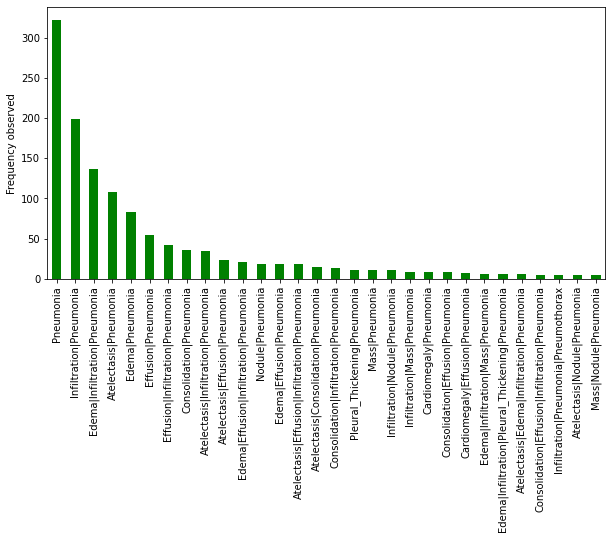

In [60]:
# Let's review some comorbitities
plt.figure(figsize=(10,5))
all_xray_df[all_xray_df['Pneumonia'] == 1]['Finding Labels'].value_counts()[0:30].plot(kind='bar', color='green')
plt.ylabel('Frequency observed')

Based on this, we can already tell that there are going to be some comorbidities we will have to attend to within some of our images. 

Infiltration, edema, and effusion all appear to occure quite frequently with pneumonia.  

It's unclear at this point how this could cause issues with our ability to make relevant classification (ie what is the degree that these other conditions could obscure/bias the signal that we're looking for). For now, file as 'notable'.

Moving on; next criteria:  
**Students create distributions of basic demographics of the patients who make up their datasets (such as age, gender, patient position,etc.)**

Consider age. Here again, statements on 'age of participants with certain diseases' would require us to acknowledge the fact that there are multiple images for (some) patients.  

As above, I am going to put the focus on description of the _images_ that are seen by the algorithm, not a statment on the prevalence of diease within the population.

/home/jared/anaconda3/envs/test/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Frequency')

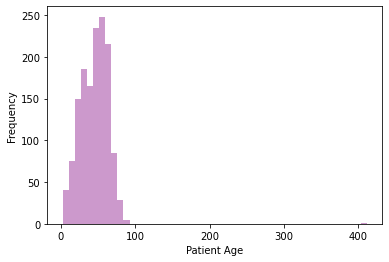

In [63]:
# What is the age distribution of patient images (emphasis) with pneumonia
sns.distplot(all_xray_df[all_xray_df['Pneumonia'] == 1]['Patient Age'], kde=False, color='purple')
plt.ylabel('Frequency')

/home/jared/anaconda3/envs/test/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Frequency')

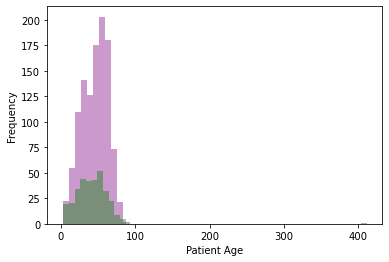

In [69]:
# I suppose I'm curious: what is the age of patients with ONLY pneumonia compared to a pneumonia with comorbidities?
pneumonia_data=all_xray_df[all_xray_df['Pneumonia'] == 1]

sns.distplot(pneumonia_data[(pneumonia_data['Pneumonia'] == 1) &\
                            (pneumonia_data['Finding Labels'].str.len() > 10) ]['Patient Age'], 
                             kde=False, color='purple')

sns.distplot(pneumonia_data[pneumonia_data['Finding Labels'] == 'Pneumonia']['Patient Age'], kde=False, color='green')

plt.ylabel('Frequency')

In [ ]:
# Need a 'description' section 

In [ ]:
## EDA
# Todo 